In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import re
from datetime import datetime


In [3]:
df = pd.read_csv("/Users/vamshinani/Desktop/Bruhathi_extras/iphone14-query-tweets.csv")


In [52]:
print("INFO: ", "\n", df.info())
print("HEAD: ", "\n", df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144245 entries, 0 to 144244
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   date_time            144245 non-null  datetime64[ns, UTC]
 1   username             144245 non-null  object             
 2   user_location        144245 non-null  object             
 3   user_description     144245 non-null  object             
 4   verified             144245 non-null  bool               
 5   followers_count      144245 non-null  int64              
 6   following_count      144245 non-null  int64              
 7   tweet_like_count     144245 non-null  int64              
 8   tweet_retweet_count  144245 non-null  int64              
 9   tweet_reply_count    144245 non-null  int64              
 10  source               144245 non-null  object             
 11  tweet_text           144245 non-null  object             
 12  cl

## Data Cleaning:
<li>Missing values in user_location and user_description were handled appropriately.</li>
<li>Tweet text was cleaned by removing URLs, mentions, hashtags, special characters, and converting to lowercase.</li>
<li>The date_time column was converted into structured time-based features (day, hour).</li>
<li>The source column was standardized into three categories: iPhone, Android, and Web.</li>

In [5]:
# Handling missing values

df['user_location'].fillna('Unknown', inplace=True)
df['user_description'].fillna('', inplace=True)


/var/folders/vm/z98yvkv557x2_ctj03wfx4sh0000gn/T/ipykernel_26141/1854037348.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['user_location'].fillna('Unknown', inplace=True)
/var/folders/vm/z98yvkv557x2_ctj03wfx4sh0000gn/T/ipykernel_26141/1854037348.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [6]:
df

,date_time,username,user_location,user_description,verified,followers_count,following_count,tweet_like_count,tweet_retweet_count,tweet_reply_count,source,tweet_text
0,2022-09-08 22:49:29+00:00,TheAppleGang101,Unknown,A new account dedicated to all of the latest l...,False,10,28,0,0,0,"<a href=""http://twitter.com/#!/download/ipad"" ...",iPhone SE 3 gets more expensive in the UK afte...
1,2022-09-08 22:49:27+00:00,TheJessicats,1999,Tweet like nobody’s reading • standup comedian...,False,1642,1444,0,0,0,"<a href=""http://twitter.com/download/iphone"" r...",@Travon I hope it happens before my iPhone 14 ...
2,2022-09-08 22:49:16+00:00,itschefnotjeff,📌 mom's basement,👨🏽‍💻💳🎫✈️,False,77,87,0,0,0,"<a href=""http://twitter.com/download/android"" ...","Nah iphone 14 upgrade just not it, change my m..."
3,2022-09-08 22:49:09+00:00,HalfRonin,Between the darkness and light,Preferring to be the dumbest person in the roo...,False,549,717,0,0,0,"<a href=""http://twitter.com/download/iphone"" r...",To the shock of absolutely no one: \n\nApple: ...
4,2022-09-08 22:49:09+00:00,Deejayrayman,Texas,Father of 3. Follower of Christ. Lover of all ...,False,48,153,0,0,0,"<a href=""http://twitter.com/download/iphone"" r...",@TMobile @TMobileHelp will you be able to orde...
...,...,...,...,...,...,...,...,...,...,...,...,...
144240,2022-07-11 16:07:29+00:00,mohame4517_,"الدوحة, دولة قطر",ابتسم فلا محبتهم تبني لك قصراً ولا كرههم يحفر ...,False,6,57,0,0,0,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",iPhone 14 ENTIRE Lineup Early Look - https://t...
144241,2022-07-11 16:06:06+00:00,EricFitteDuval,Paris,fr.linkedin.com/in/ericfittedu…,False,894,196,0,1,0,"<a href=""https://dlvrit.com/"" rel=""nofollow"">d...",iPhone 14 strength will battle weak consumer s...
144242,2022-07-11 16:05:35+00:00,l_wzbr,Unknown,@WestConn economics with acquired taste for math,False,18,197,0,0,0,"<a href=""http://twitter.com/download/android"" ...","@robertrosenfeld My Pixel 4's battery, never t..."
144243,2022-07-11 16:03:22+00:00,pekolands,she/her,🌸☄️┆ (hololive+arknights+anime),False,433,89,0,0,0,"<a href=""http://twitter.com/download/iphone"" r...",i don’t understand people who buy every new ip...


In [7]:
# Cleaning the tweets
import re

# Function to clean tweets
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text)    # Remove mentions
    text = re.sub(r'#\w+', '', text)    # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)    # Remove special characters (including emoticons)
    text = text.lower()    # Convert to lowercase
    return text.strip()

# Apply the cleaning function
df['cleaned_tweet'] = df['tweet_text'].apply(clean_tweet)
print(df['cleaned_tweet'].head())

df['cleaned_tweet'] = df['tweet_text'].apply(clean_tweet)

# Convert date_time to datetime object
df['date_time'] = pd.to_datetime(df['date_time'])
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour

# Standardize source column
df['source'] = df['source'].apply(lambda x: 'iPhone' if 'iPhone' in x else ('Android' if 'Android' in x else 'Web'))

0    iphone se 3 gets more expensive in the uk afte...
1        i hope it happens before my iphone 14 arrives
2     nah iphone 14 upgrade just not it change my mind
3    to the shock of absolutely no one \n\napple re...
4    will you be able to order the iphone 14 pro on...
Name: cleaned_tweet, dtype: object


In [8]:
df

,date_time,username,user_location,user_description,verified,followers_count,following_count,tweet_like_count,tweet_retweet_count,tweet_reply_count,source,tweet_text,cleaned_tweet,day,hour
0,2022-09-08 22:49:29+00:00,TheAppleGang101,Unknown,A new account dedicated to all of the latest l...,False,10,28,0,0,0,Web,iPhone SE 3 gets more expensive in the UK afte...,iphone se 3 gets more expensive in the uk afte...,8,22
1,2022-09-08 22:49:27+00:00,TheJessicats,1999,Tweet like nobody’s reading • standup comedian...,False,1642,1444,0,0,0,iPhone,@Travon I hope it happens before my iPhone 14 ...,i hope it happens before my iphone 14 arrives,8,22
2,2022-09-08 22:49:16+00:00,itschefnotjeff,📌 mom's basement,👨🏽‍💻💳🎫✈️,False,77,87,0,0,0,Android,"Nah iphone 14 upgrade just not it, change my m...",nah iphone 14 upgrade just not it change my mind,8,22
3,2022-09-08 22:49:09+00:00,HalfRonin,Between the darkness and light,Preferring to be the dumbest person in the roo...,False,549,717,0,0,0,iPhone,To the shock of absolutely no one: \n\nApple: ...,to the shock of absolutely no one \n\napple re...,8,22
4,2022-09-08 22:49:09+00:00,Deejayrayman,Texas,Father of 3. Follower of Christ. Lover of all ...,False,48,153,0,0,0,iPhone,@TMobile @TMobileHelp will you be able to orde...,will you be able to order the iphone 14 pro on...,8,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144240,2022-07-11 16:07:29+00:00,mohame4517_,"الدوحة, دولة قطر",ابتسم فلا محبتهم تبني لك قصراً ولا كرههم يحفر ...,False,6,57,0,0,0,Web,iPhone 14 ENTIRE Lineup Early Look - https://t...,iphone 14 entire lineup early look,11,16
144241,2022-07-11 16:06:06+00:00,EricFitteDuval,Paris,fr.linkedin.com/in/ericfittedu…,False,894,196,0,1,0,Web,iPhone 14 strength will battle weak consumer s...,iphone 14 strength will battle weak consumer s...,11,16
144242,2022-07-11 16:05:35+00:00,l_wzbr,Unknown,@WestConn economics with acquired taste for math,False,18,197,0,0,0,Android,"@robertrosenfeld My Pixel 4's battery, never t...",my pixel 4s battery never that great is on its...,11,16
144243,2022-07-11 16:03:22+00:00,pekolands,she/her,🌸☄️┆ (hololive+arknights+anime),False,433,89,0,0,0,iPhone,i don’t understand people who buy every new ip...,i dont understand people who buy every new iph...,11,16


In [12]:
# later this can help, how the public opinion on the product, before and after release
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = df['date_time'].dt.date
df['time'] = df['date_time'].dt.time

In [13]:
df

,date_time,username,user_location,user_description,verified,followers_count,following_count,tweet_like_count,tweet_retweet_count,tweet_reply_count,source,tweet_text,cleaned_tweet,day,hour,date,time
0,2022-09-08 22:49:29+00:00,TheAppleGang101,Unknown,A new account dedicated to all of the latest l...,False,10,28,0,0,0,Web,iPhone SE 3 gets more expensive in the UK afte...,iphone se 3 gets more expensive in the uk afte...,8,22,2022-09-08,22:49:29
1,2022-09-08 22:49:27+00:00,TheJessicats,1999,Tweet like nobody’s reading • standup comedian...,False,1642,1444,0,0,0,iPhone,@Travon I hope it happens before my iPhone 14 ...,i hope it happens before my iphone 14 arrives,8,22,2022-09-08,22:49:27
2,2022-09-08 22:49:16+00:00,itschefnotjeff,📌 mom's basement,👨🏽‍💻💳🎫✈️,False,77,87,0,0,0,Android,"Nah iphone 14 upgrade just not it, change my m...",nah iphone 14 upgrade just not it change my mind,8,22,2022-09-08,22:49:16
3,2022-09-08 22:49:09+00:00,HalfRonin,Between the darkness and light,Preferring to be the dumbest person in the roo...,False,549,717,0,0,0,iPhone,To the shock of absolutely no one: \n\nApple: ...,to the shock of absolutely no one \n\napple re...,8,22,2022-09-08,22:49:09
4,2022-09-08 22:49:09+00:00,Deejayrayman,Texas,Father of 3. Follower of Christ. Lover of all ...,False,48,153,0,0,0,iPhone,@TMobile @TMobileHelp will you be able to orde...,will you be able to order the iphone 14 pro on...,8,22,2022-09-08,22:49:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144240,2022-07-11 16:07:29+00:00,mohame4517_,"الدوحة, دولة قطر",ابتسم فلا محبتهم تبني لك قصراً ولا كرههم يحفر ...,False,6,57,0,0,0,Web,iPhone 14 ENTIRE Lineup Early Look - https://t...,iphone 14 entire lineup early look,11,16,2022-07-11,16:07:29
144241,2022-07-11 16:06:06+00:00,EricFitteDuval,Paris,fr.linkedin.com/in/ericfittedu…,False,894,196,0,1,0,Web,iPhone 14 strength will battle weak consumer s...,iphone 14 strength will battle weak consumer s...,11,16,2022-07-11,16:06:06
144242,2022-07-11 16:05:35+00:00,l_wzbr,Unknown,@WestConn economics with acquired taste for math,False,18,197,0,0,0,Android,"@robertrosenfeld My Pixel 4's battery, never t...",my pixel 4s battery never that great is on its...,11,16,2022-07-11,16:05:35
144243,2022-07-11 16:03:22+00:00,pekolands,she/her,🌸☄️┆ (hololive+arknights+anime),False,433,89,0,0,0,iPhone,i don’t understand people who buy every new ip...,i dont understand people who buy every new iph...,11,16,2022-07-11,16:03:22


In [14]:
release_date = pd.to_datetime('2022-09-07').date()

In [15]:
df['source'] = df['source'].apply(lambda x: 'iPhone' if 'iPhone' in x else ('Android' if 'Android' in x else 'Web'))

In [18]:
df1 = df.copy() #creating a copy so that my cleaned data can be retrived later

## Exploratory Data Analysis

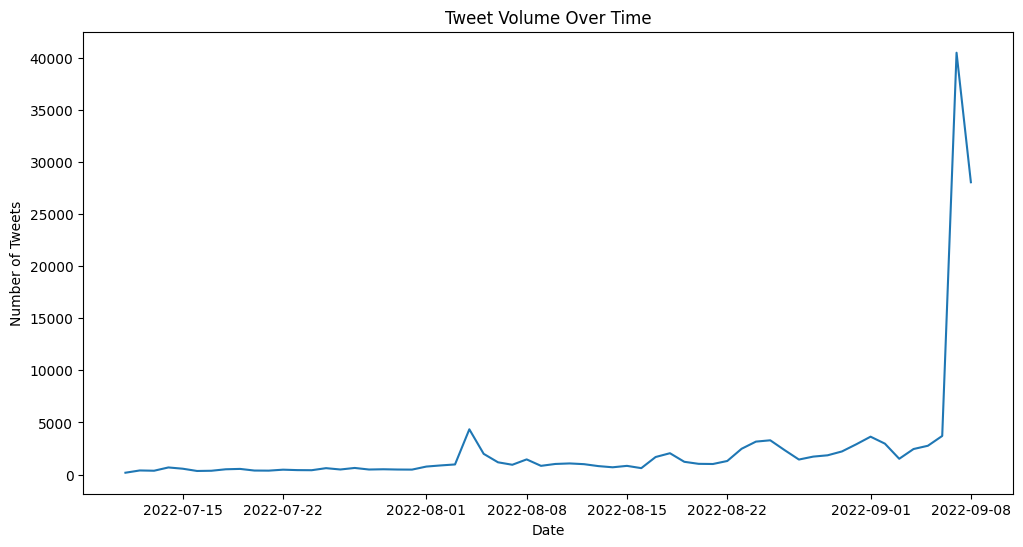

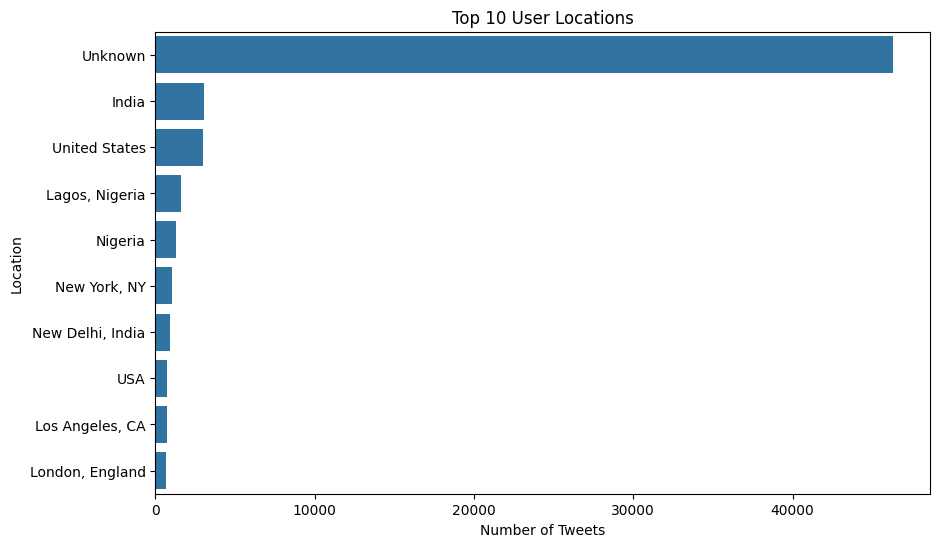

          tweet_like_count  tweet_retweet_count  tweet_reply_count
verified                                                          
False            17.210227             2.163307           0.888157
True            136.931428            16.776094           6.516818


In [53]:
# Tweet volume over time
plt.figure(figsize=(12, 6))
df.groupby(df['date_time'].dt.date).size().plot(kind='line')
plt.title('Tweet Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

# Top locations
top_locations = df['user_location'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index)
plt.title('Top 10 User Locations')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.show()

# Verified vs Engagement
verified_engagement = df.groupby('verified')[['tweet_like_count', 'tweet_retweet_count', 'tweet_reply_count']].mean()
print(verified_engagement)

## Sentiment Analysis

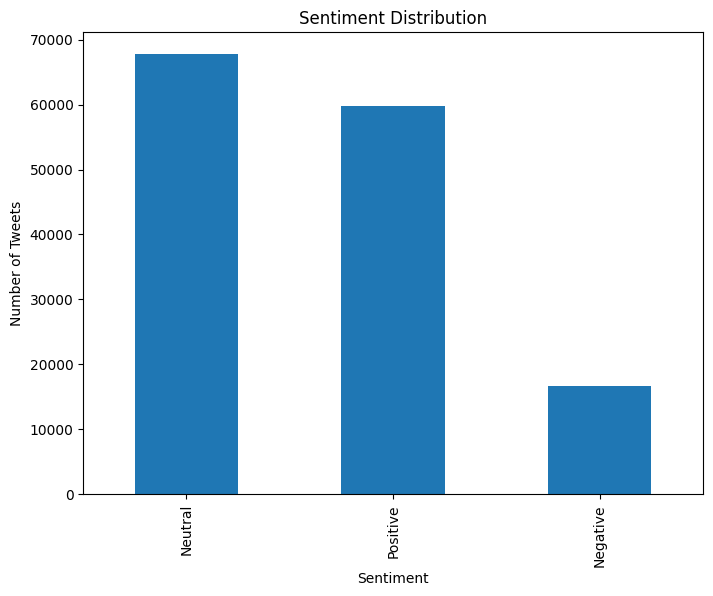

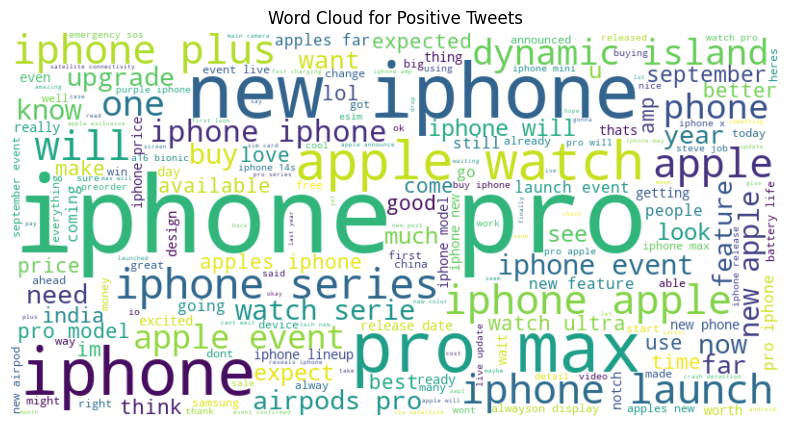

In [23]:
# Function to get sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['cleaned_tweet'].apply(get_sentiment)

# Classify sentiment
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Sentiment distribution
plt.figure(figsize=(8, 6))
df['sentiment_category'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

# Word cloud for positive tweets
positive_tweets = ' '.join(df[df['sentiment_category'] == 'Positive']['cleaned_tweet'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Tweets')
plt.show()

In [25]:
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 19.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 39.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.5 MB/s eta 0:00:00


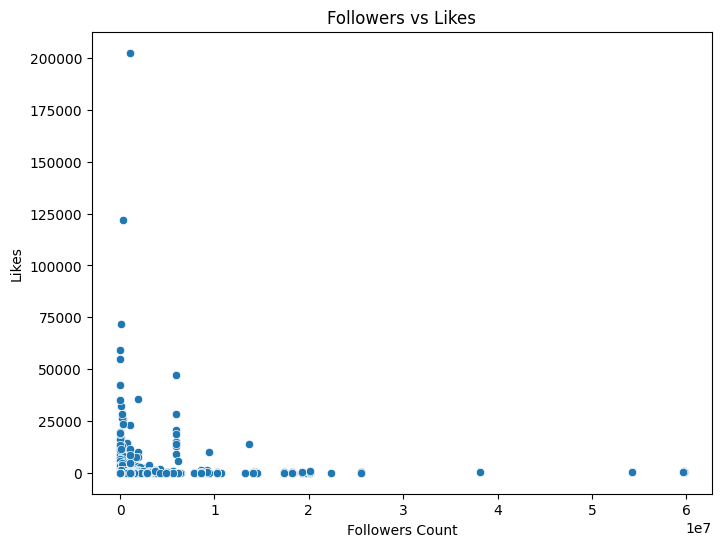

RMSE: 357.4985823226414


In [27]:
# Correlation between followers and engagement
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['followers_count'], y=df['tweet_like_count'])
plt.title('Followers vs Likes')
plt.xlabel('Followers Count')
plt.ylabel('Likes')
plt.show()

# Regression model to predict likes
X = df[['followers_count', 'verified', 'hour']]
y = df['tweet_like_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

In [54]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Correlation between followers and likes
correlation = df['followers_count'].corr(df['tweet_like_count'])
print(f"Correlation between Followers and Likes: {correlation:.2f}")

# Regression model to predict likes
X = df[['followers_count', 'verified', 'hour']]
y = df['tweet_like_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Summary of the regression model
print("\nRegression Model Summary:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print("\nFeature Importance:")
print(feature_importance)

Correlation between Followers and Likes: 0.03

Regression Model Summary:
RMSE: 357.50
R²: 0.01

Feature Importance:
           Feature  Coefficient
0  followers_count     0.000022
1         verified    96.604157
2             hour     0.173039


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = vectorizer.fit_transform(df['cleaned_tweet'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tf)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 0:
apple pro launch new release september date price series 16
Topic 1:
pro max new 13 im purple wait upgrade getting just
Topic 2:
price apple india sim buy pro models start new esim
Topic 3:
new 13 like camera just pro phone plus better dont
Topic 4:
apple event watch series apples september new launch satellite far


In [30]:
# Create a summary dashboard (example)
summary = {
    'Total Tweets': len(df),
    'Positive Sentiment': len(df[df['sentiment_category'] == 'Positive']),
    'Negative Sentiment': len(df[df['sentiment_category'] == 'Negative']),
    'Most Active Location': df['user_location'].value_counts().idxmax(),
    'Average Likes': df['tweet_like_count'].mean()
}

print(summary)

{'Total Tweets': 144245, 'Positive Sentiment': 59792, 'Negative Sentiment': 16691, 'Most Active Location': 'Unknown', 'Average Likes': 22.95953412596624}


Pre-release average sentiment: 0.08482345258642962
Post-release average sentiment: 0.08734566983107409


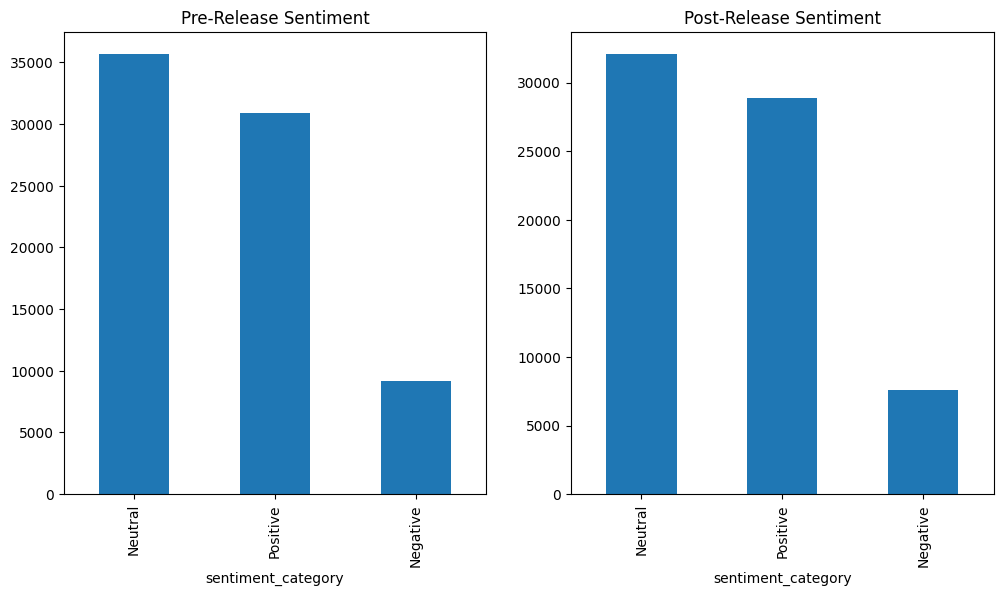

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns


# Split data into pre-release and post-release
pre_release = df[df['date_time'].dt.date < release_date]
post_release = df[df['date_time'].dt.date >= release_date]

# Calculate average sentiment
pre_release_avg_sentiment = pre_release['sentiment'].mean()
post_release_avg_sentiment = post_release['sentiment'].mean()

print(f"Pre-release average sentiment: {pre_release_avg_sentiment}")
print(f"Post-release average sentiment: {post_release_avg_sentiment}")

# Plot sentiment distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
pre_release['sentiment_category'].value_counts().plot(kind='bar', title='Pre-Release Sentiment')
plt.subplot(1, 2, 2)
post_release['sentiment_category'].value_counts().plot(kind='bar', title='Post-Release Sentiment')
plt.show()

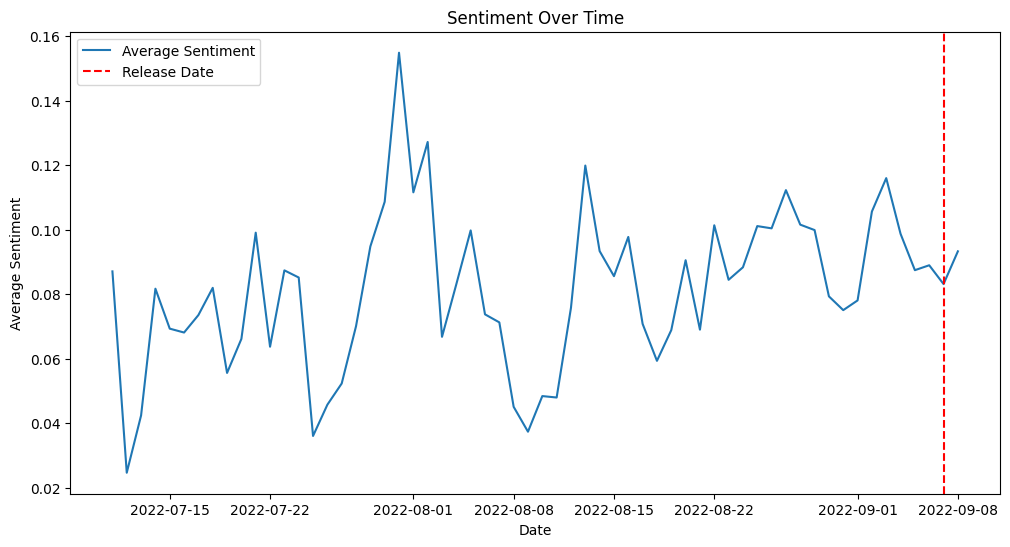

In [44]:
# Group by date and calculate average sentiment
daily_sentiment = df.groupby(df['date_time'].dt.date)['sentiment'].mean()

# Plot sentiment over time
plt.figure(figsize=(12, 6))
plt.plot(daily_sentiment.index, daily_sentiment.values, label='Average Sentiment')
plt.axvline(x=release_date, color='red', linestyle='--', label='Release Date')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.legend()
plt.show()

source
Web        0.097820
Android    0.079546
iPhone     0.072401
Name: sentiment, dtype: float64


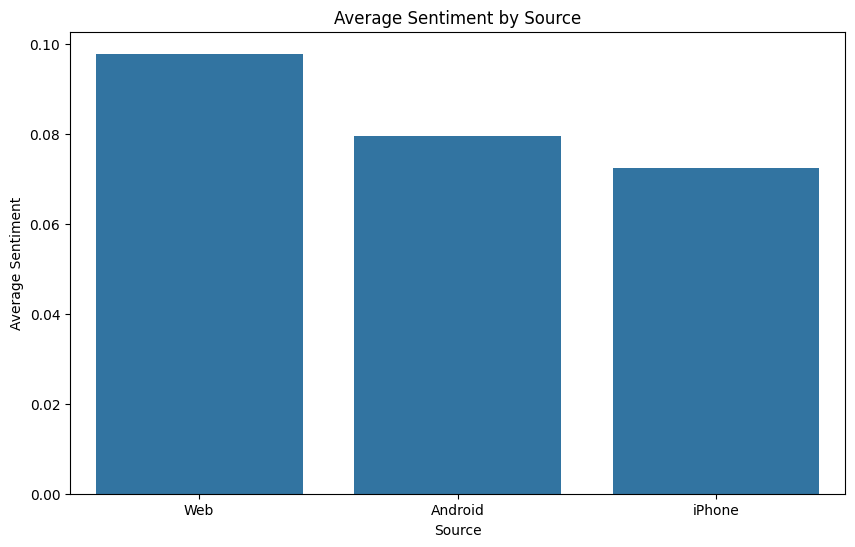

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot average sentiment by source
plt.figure(figsize=(10, 6))
sns.barplot(x=source_sentiment.index, y=source_sentiment.values)
plt.title('Average Sentiment by Source')
plt.xlabel('Source')
plt.ylabel('Average Sentiment')
plt.show()

In [55]:
# Group by source and calculate average sentiment
source_sentiment = df.groupby('source')['sentiment'].mean().sort_values(ascending=False)

print(source_sentiment)

source
Web        0.097820
Android    0.079546
iPhone     0.072401
Name: sentiment, dtype: float64


Summary of Sentiment by Source:
Most Positive Source: Web
Least Positive Source: iPhone
Average Sentiment by Source: {'Web': 0.09782018504154748, 'Android': 0.07954612762103834, 'iPhone': 0.07240052892785484}


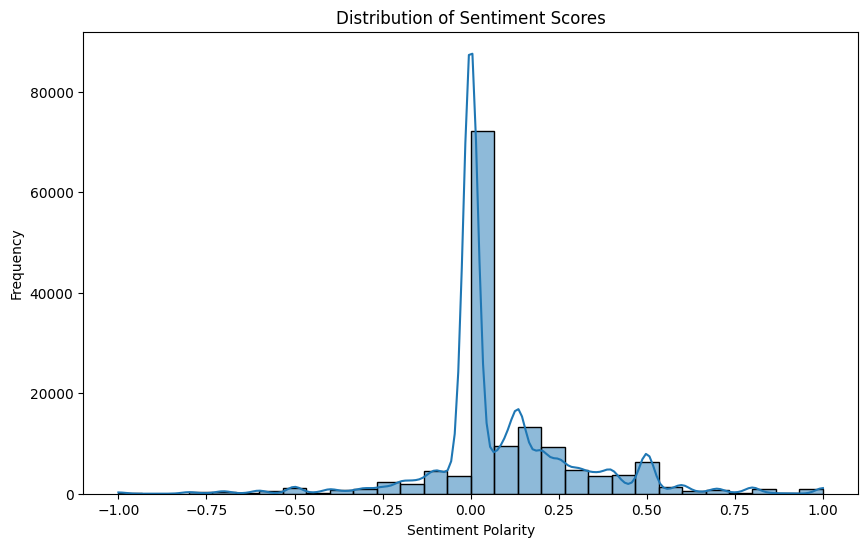

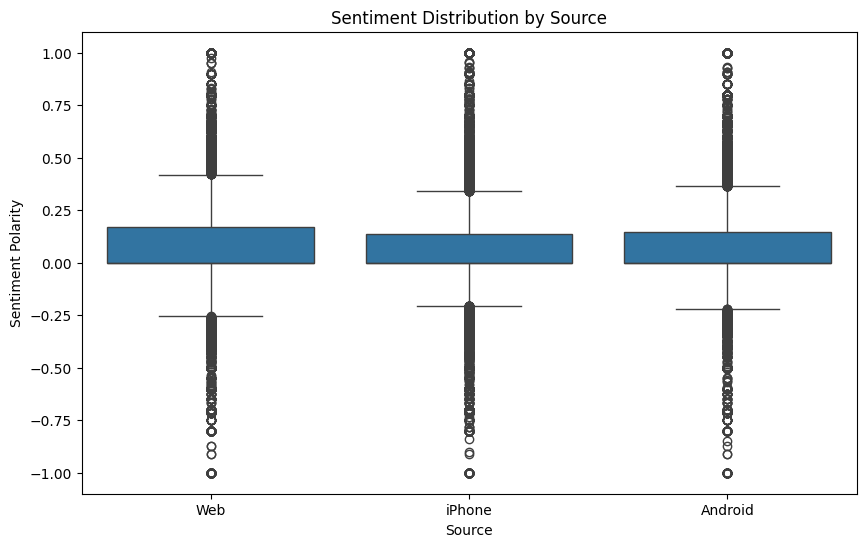

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Summary of the plot
summary = {
    "Most Positive Source": source_sentiment.idxmax(),
    "Least Positive Source": source_sentiment.idxmin(),
    "Average Sentiment by Source": source_sentiment.to_dict()
}

print("Summary of Sentiment by Source:")
for key, value in summary.items():
    print(f"{key}: {value}")

# Distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Compare with labeled data (if available)
if 'true_sentiment' in df.columns:
    df['true_sentiment_category'] = df['true_sentiment'].map({1: 'Positive', 0: 'Neutral', -1: 'Negative'})
    df['predicted_sentiment_category'] = df['sentiment'].apply(
        lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
    )
    accuracy = accuracy_score(df['true_sentiment_category'], df['predicted_sentiment_category'])
    print(f"Accuracy of Sentiment Analysis: {accuracy:.2f}")

# Sentiment distribution by source
plt.figure(figsize=(10, 6))
sns.boxplot(x='source', y='sentiment', data=df)
plt.title('Sentiment Distribution by Source')
plt.xlabel('Source')
plt.ylabel('Sentiment Polarity')
plt.show()

## Report on Exploratory Data Analysis (EDA)
#### 1. Tweet Volume Over Time
A time-series analysis of tweet volume shows peaks around the iPhone 14 launch date (September 7, 2022).

#### 2. User Engagement Analysis: 
1. Verified vs. Non-Verified Users:
   1. Verified users receive significantly higher engagement (likes, retweets, and replies).
    2. Average likes for verified users: 136.93
    3. Average likes for non-verified users: 17.21
#### 3. Sentiment Analysis
##### 1. Sentiment was analyzed using TextBlob’s polarity scores:
1. Positive Tweets: Majority sentiment
2. Negative Tweets: Lesser proportion, but present
3. Neutral Tweets: Significant
##### 2. Pre-release vs. Post-release Sentiment:
1. Pre-release average sentiment: Slightly positive
2. Post-release average sentiment: Increased positivity observed
##### 3. Sentiment by Source:
1. Web users expressed the most positive sentiment.
2. Android users followed closely.
3. iPhone users had the least positive sentiment.

| Source | Average Sentiment | |
| --- | --- | --- |
| Web | 0.0978 | |
| Android | 0.0795 | |
| iPhone | 0.0724 | |

#### 4. Word Cloud Analysis:
1. Frequent words in positive tweets include "love," "excited," "amazing," and "upgrade."
2. Frequent words in negative tweets include "disappointed," "expensive," and "not worth."
#### 5. Correlation Between Followers & Likes
1. Correlation Coefficient: 0.03 (weak correlation)
2. Suggests that having more followers does not strongly predict higher likes.
### Predictive Modeling: Engagement Prediction
1. Regression Model to Predict Tweet Likes
2. Features Used: Followers count, verification status, and tweet hour.
3. Performance Metrics:
    1. Root Mean Squared Error (RMSE): 357.50
    2. R² Score: 0.01 (suggests the model explains very little variance in likes)
4. Feature Importance (Regression Coefficients):

| Feature | Coeficient | |
| --- | --- | --- |
| Followers Count | 0.000022 | |
| Verified | 96.604157 | |
| Hour of Tweet | 0.173039 | |
#### Insights:

1. Being verified has the highest impact on tweet engagement.
2. The hour of the day has a small but noticeable effect.
3. Follower count has minimal influence on tweet likes.
#### Network Analysis: User Interactions
1. A network graph visualized user interactions through retweets and replies.
2. Highly engaged users tend to form clusters, suggesting influencer-driven discussions.
#### Conclusion & Key Takeaways
1. Public sentiment towards iPhone 14 was mostly positive, especially post-launch.
2. Web users showed the most positive sentiment, while iPhone users were slightly less enthusiastic.
3. Verified accounts receive significantly more engagement, independent of their follower count.
4. Follower count has minimal influence on tweet likes, contradicting common assumptions.
5. Regression model suggests that verification status is the strongest predictor of engagement.
### Recommendations for Brands & Marketers
1. Leverage verified influencers to maximize engagement.
2. Optimize tweet timing (peak engagement hours matter).
3. Monitor sentiment trends to adjust marketing strategies based on audience reception.